In [1]:
import numpy as np
try:
    import cv2
    if not hasattr(cv2, 'imread'):
        from cv2 import cv2
except ImportError:
    raise ImportError("OpenCV (cv2) is not properly installed. Please install it using: pip install opencv-python")
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import joblib


In [2]:
# Load train features after PCA
train_features_df_pca = pd.read_csv('train_features_pca.csv')
X_train_pca = train_features_df_pca.drop('Category', axis=1).values
y_train = train_features_df_pca['Category']

# Load test features after PCA
test_features_df_pca = pd.read_csv('test_features_pca.csv')
X_test_pca = test_features_df_pca.drop('Category', axis=1).values
y_test = test_features_df_pca['Category']



In [3]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical labels to numbers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Create and configure Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'  # For class balancing
)

# Train and predict
rf.fit(X_train_pca, y_train_encoded)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [4]:
test_predictions = rf.predict(X_test_pca)
test_probabilities = rf.predict_proba(X_test_pca)


In [7]:
from sklearn.metrics import auc, roc_curve


def plot_results(train_df, test_df, y_true, y_pred, classes, test_probabilities):
    """Plot essential visualizations with improved styling"""
    # Set style
    plt.style.use('seaborn-v0_8')
    
    # Class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training distribution
    train_dist = train_df['Category'].value_counts()
    sns.barplot(x=train_dist.index, y=train_dist.values, ax=ax1, 
                palette='viridis', hue=train_dist.index, legend=False)
    ax1.set_title('Training Set Distribution', pad=15, fontsize=12, fontweight='bold')
    ax1.set_xlabel('Category', fontsize=10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
    
    # Test distribution
    test_dist = test_df['Category'].value_counts()
    sns.barplot(x=test_dist.index, y=test_dist.values, ax=ax2,
                palette='viridis', hue=test_dist.index, legend=False)
    ax2.set_title('Test Set Distribution', pad=15, fontsize=12, fontweight='bold')
    ax2.set_xlabel('Category', fontsize=10)
    ax2.set_ylabel('Count', fontsize=10)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Confusion matrix with improved styling
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=classes, yticklabels=classes,
                square=True, cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('True Label', fontsize=11)
    plt.title('Confusion Matrix', pad=20, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy with improved styling
    class_accuracy = {}
    for i, cls in enumerate(classes):
        mask = y_true == i
        class_accuracy[cls] = accuracy_score(y_true[mask], y_pred[mask])
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_accuracy.keys(), class_accuracy.values(),
                   color=plt.cm.viridis(np.linspace(0, 1, len(classes))))
    plt.title('Per-Class Accuracy', pad=15, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy', fontsize=11)
    plt.xlabel('Category', fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # ROC curves with improved styling
    plt.figure(figsize=(13, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    
    for i, (cls, color) in enumerate(zip(classes, colors)):
        y_true_binary = (y_true == i).astype(int)
        y_score = test_probabilities[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                label=f'{cls} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title('ROC Curves (One-vs-Rest)', pad=15, fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\nModel Performance:")
    print(classification_report(y_true, y_pred, target_names=classes))


C:\Users\Sidhartha Garg\AppData\Local\Temp\ipykernel_6760\978283710.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
C:\Users\Sidhartha Garg\AppData\Local\Temp\ipykernel_6760\978283710.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')


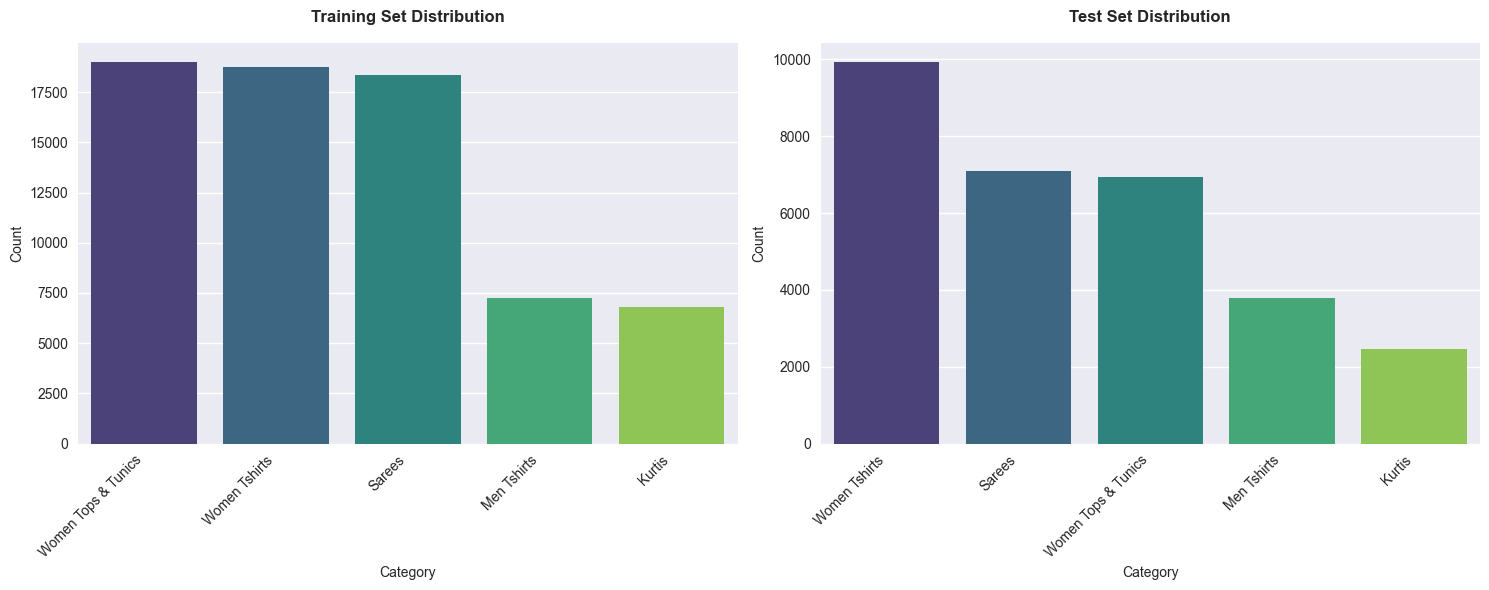

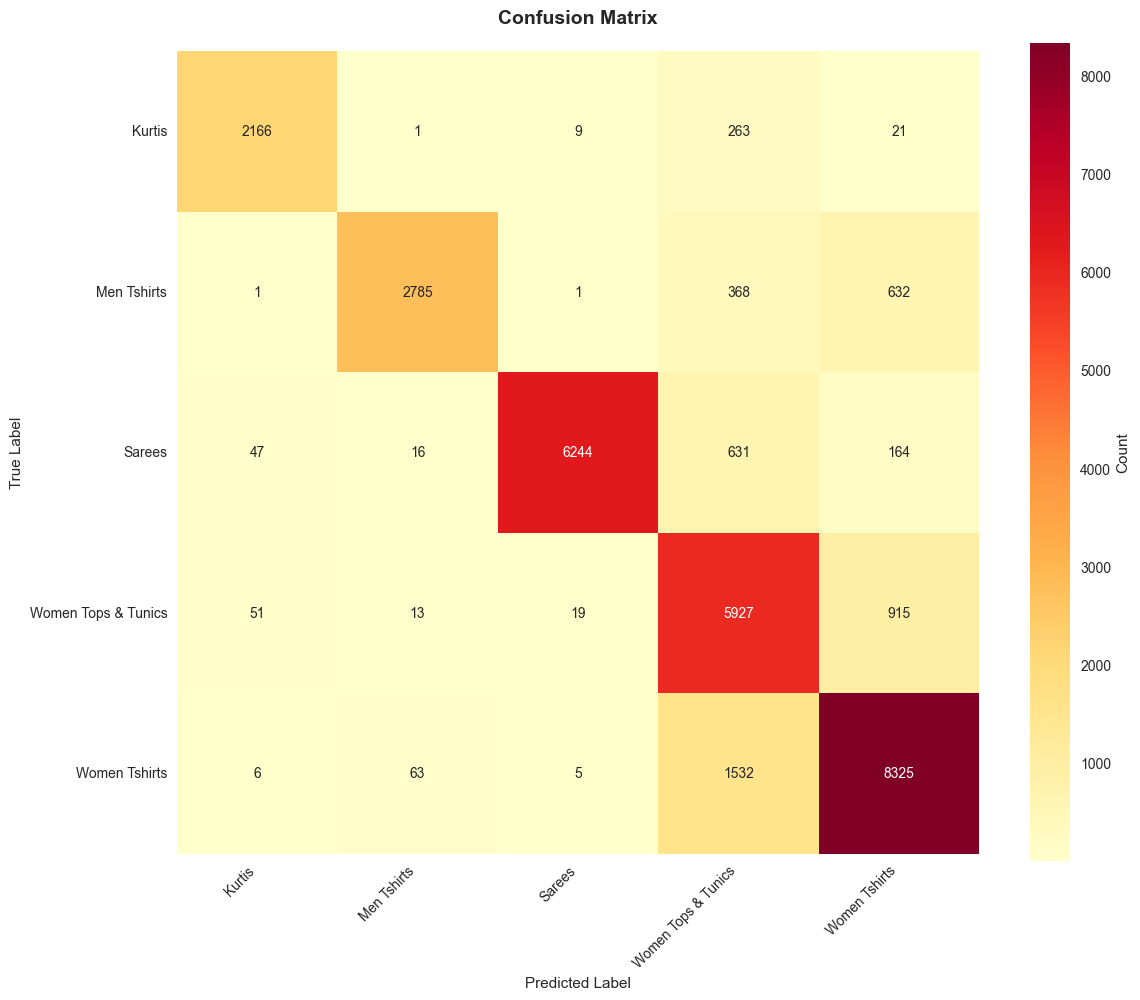

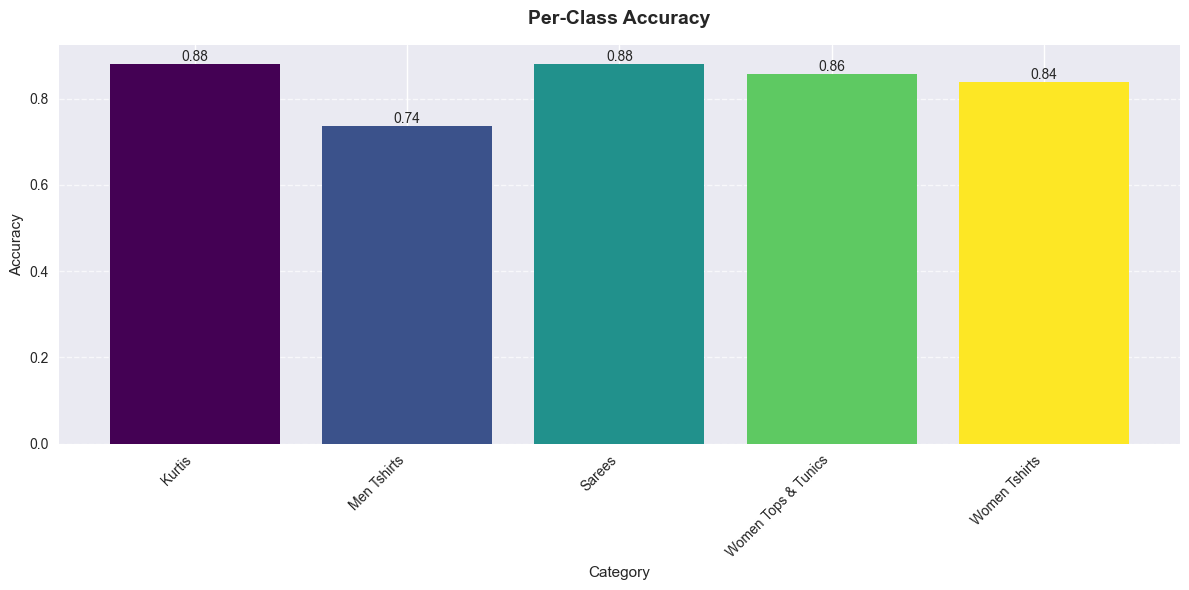

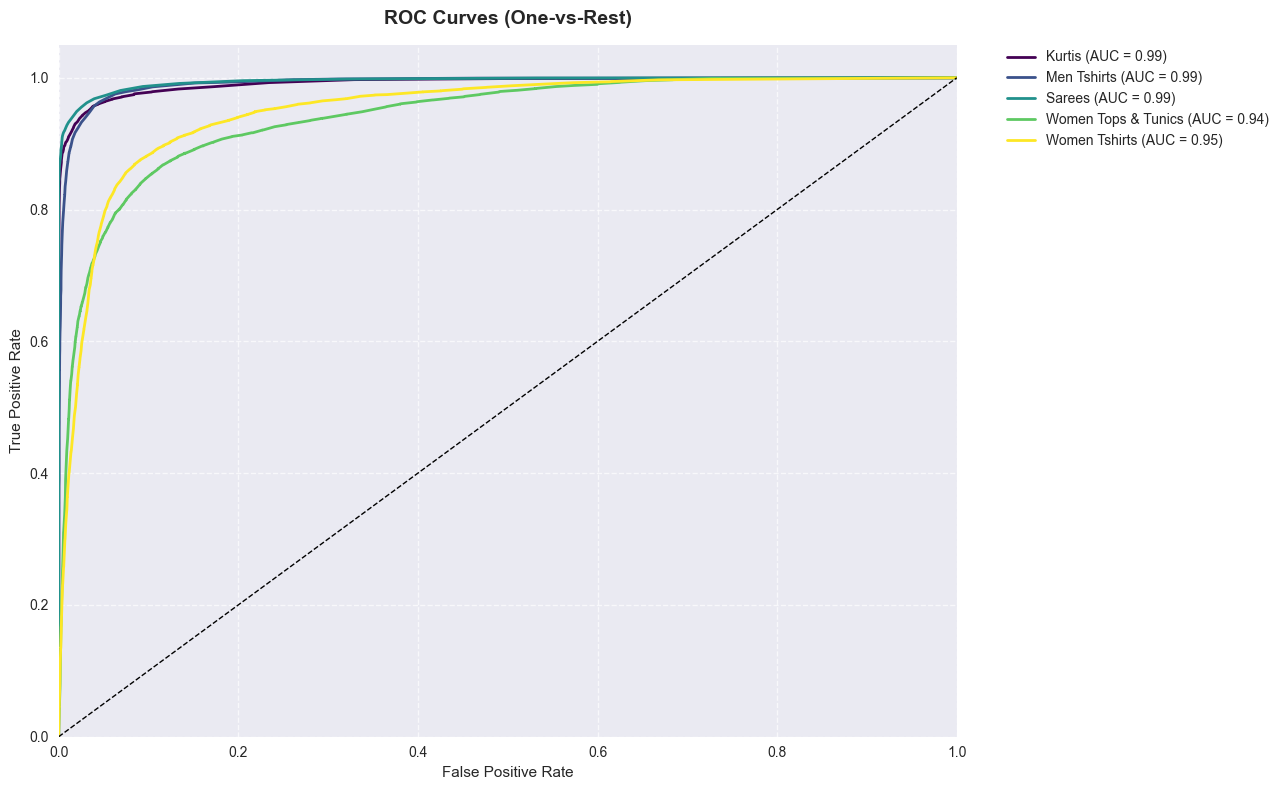


Model Performance:
                     precision    recall  f1-score   support

             Kurtis       0.95      0.88      0.92      2460
        Men Tshirts       0.97      0.74      0.84      3787
             Sarees       0.99      0.88      0.93      7102
Women Tops & Tunics       0.68      0.86      0.76      6925
      Women Tshirts       0.83      0.84      0.83      9931

           accuracy                           0.84     30205
          macro avg       0.88      0.84      0.86     30205
       weighted avg       0.86      0.84      0.85     30205



In [8]:
classes = le.classes_
plot_results(train_features_df_pca, test_features_df_pca,
             y_test_encoded, test_predictions, classes, test_probabilities)